In [20]:
# 라이브러리 모음

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
import numpy as np
import cv2

from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings

warnings.filterwarnings('ignore')

In [21]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img)
        l = self.clahe.apply(l)
        img = cv2.merge((l, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        return Image.fromarray(img)

class GammaCorrection:
    def __init__(self, gamma=1.0):
        self.gamma = gamma
        
    def __call__(self, img):
        img = np.array(img)
        img = img / 255.0
        img = np.power(img, self.gamma)
        img = np.uint8(img * 255)
        return Image.fromarray(img)

In [22]:
# 데이터 증강용 변환 함수

transform = transforms.Compose(
    [
        # transforms.Resize((255, 255)),
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        CLAHETransform(clip_limit=5.0, tile_grid_size=(8, 8)),
        GammaCorrection(gamma=0.45),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])

   ]
)

In [23]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("archive/train", transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder("archive/valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("archive/test", transform=transform)
test_set.transform

Compose(
    Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

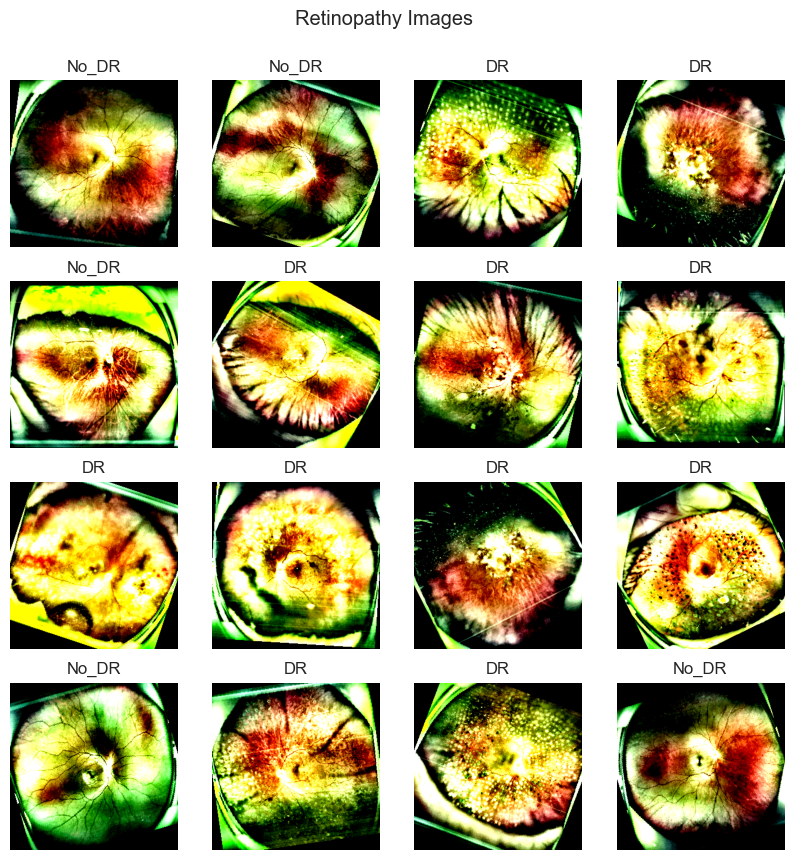

In [24]:
# Visualizing some images from Trainset
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

In [25]:
# Import and load Train, Validation and Test set
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [26]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader,"Test data": test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 299, 299])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([8, 3, 299, 299])
Shape of y: torch.Size([8]) torch.int64

Test data:
Shape of X : torch.Size([6, 3, 299, 299])
Shape of y: torch.Size([6]) torch.int64



In [27]:
# ResNet 모델 정의
def create_resnet_model(num_classes):
    # model = resnet18(pretrained=True)
    # model = resnet34(pretrained=True)
    # model = resnet50(pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    # 마지막 레이어의 출력 크기를 우리의 클래스 수로 변경
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [28]:
# 모델 생성
Retino_model = create_resnet_model(num_classes=2)


# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

Using cache found in C:\Users\Administrator/.cache\torch\hub\pytorch_vision_v0.10.0


In [29]:
Retino_model.__class__.__name__

'GoogLeNet'

In [30]:

# Model Summary for ResNet
# summary(Retino_model, input_size=(3, 255, 255), device=device.type)
summary(Retino_model, input_size=(3, 299, 299), device=device.type)

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
       BasicConv2d-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]           4,096
       BatchNorm2d-6           [-1, 64, 75, 75]             128
       BasicConv2d-7           [-1, 64, 75, 75]               0
            Conv2d-8          [-1, 192, 75, 75]         110,592
       BatchNorm2d-9          [-1, 192, 75, 75]             384
      BasicConv2d-10          [-1, 192, 75, 75]               0
        MaxPool2d-11          [-1, 192, 37, 37]               0
           Conv2d-12           [-1, 64, 37, 37]          12,288
      BatchNorm2d-13           [-1, 64, 37, 37]             128
      BasicConv2d-14           [-1, 64,

In [31]:
# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

#model이 인셉션일때
def loss_batch(loss_func, output, target, opt=None):
    # Inception 모델의 경우 logits을 추출
    if isinstance(output, (tuple, list)):
        output = output[0]  # output이 튜플이나 리스트인 경우 첫 번째 요소 추출
    
    if hasattr(output, 'logits'):
        output = output.logits

    loss = loss_func(output, target)  # 손실 계산
    pred = output.argmax(dim=1, keepdim=True)  # 예측된 클래스
    metric_b = pred.eq(target.view_as(pred)).sum().item()  # 성능 지표 계산
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [32]:
loss_func = nn.NLLLoss(reduction="sum")

opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [33]:
def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [34]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 150,
 "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GoogLeNet Loss-Acc')

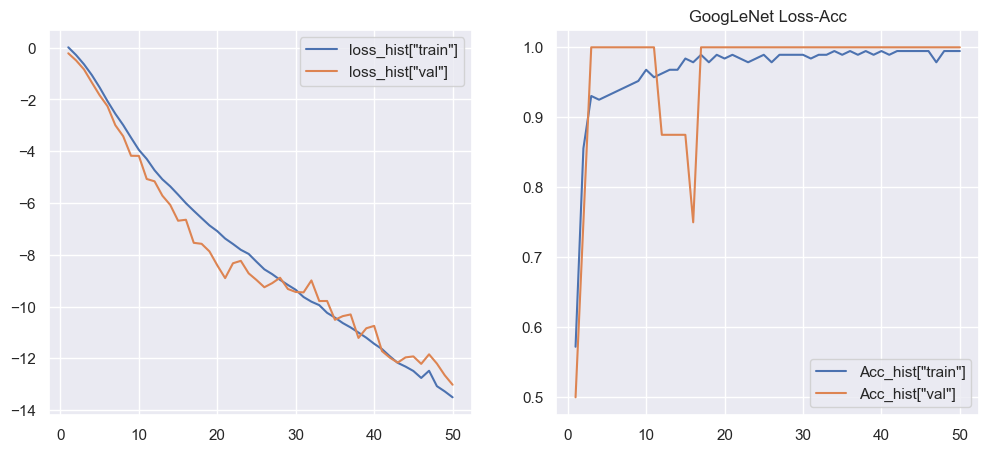

In [35]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

plt.title(f"{Retino_model.__class__.__name__} Loss-Acc")

Accuracy: 1.0000
AUROC: 1.0000
AUPRC: 1.0000


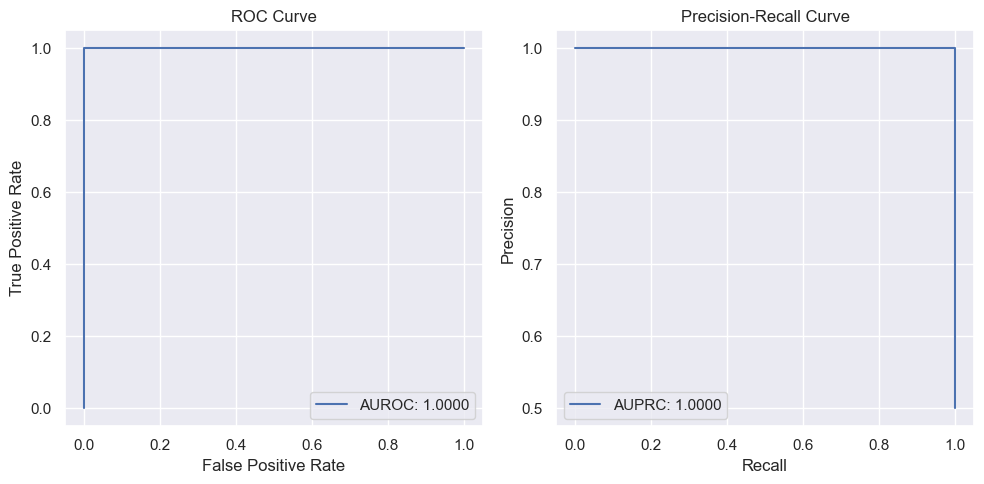

In [36]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# 모델 평가 함수
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            probs = torch.exp(output)
            preds = probs.argmax(dim=1)
            all_labels.extend(yb.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of the positive class

    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    return accuracy, auroc, auprc, all_labels, all_preds, all_probs

# 모델 평가
accuracy, auroc, auprc, all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUROC: {auroc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUPRC: {auprc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


In [37]:
torch.save(model.state_dict(), "google/model_weights.pth")

In [38]:
print(128**3 > 80*192*128)

True
